In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/tweets_features.csv", encoding='latin')
df.drop(['is_after_certain_day', 'Date', 'User', 'Text', 'Time', 'Full_date'], axis=1, inplace=True)

In [3]:
df.head()

,Target,Weekday,Length,Hashtags,HasHashtags,Mentions,HasMentions,ExclamationMarks,HasExclamationMarks,Emoticons,...,w2v_90,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99
0,0,4,111,0,False,0,False,0,False,[],...,0.576463,0.272287,-0.270659,0.398829,0.806970,0.539171,0.261823,-0.655965,0.179224,-0.132590
1,0,2,131,0,False,0,False,0,False,[],...,0.400095,0.262307,0.052329,0.443299,0.895985,0.565586,0.221301,-0.797784,0.020691,0.002357
2,0,1,41,0,False,1,True,2,True,[],...,0.460558,0.378846,-0.171764,0.227248,0.303033,0.620672,0.146584,-0.615910,0.112132,-0.088989
3,0,6,72,0,False,0,False,0,False,[],...,0.535103,0.073591,-0.307203,0.651506,0.309582,0.018715,-0.205674,-0.595330,0.333111,0.001450
4,1,0,57,0,False,1,True,0,False,[],...,0.484578,0.324513,-0.259205,0.183831,0.745856,0.448028,0.359533,-0.555516,-0.176974,-0.091381


In [4]:
selected_columns = ['Negative_VADER', 'skewed_hour_dist', 'Weekday', 'Compound_VADER',
                    'skewed_week_dist', 'w2v_11', 'Mentions', 'Polarity_TB', 'w2v_27',
                    'w2v_53', 'Hour', 'w2v_44', 'w2v_84', 'embedding_16', 'w2v_47',
                    'Positive_VADER', 'embedding_239', 'Length', 'embedding_284',
                    'embedding_263', 'embedding_153', 'embedding_301', 'w2v_76',
                    'embedding_220', 'embedding_366', 'w2v_29', 'w2v_61', 'embedding_28',
                    'embedding_168', 'embedding_272', 'embedding_253', 'embedding_85',
                    'embedding_285', 'w2v_12', 'w2v_31', 'embedding_120', 'embedding_254',
                    'w2v_73', 'w2v_67', 'embedding_174', 'embedding_225', 'embedding_297',
                    'embedding_68', 'embedding_211', 'embedding_178']

df = df[selected_columns + ['Target']]

In [5]:
def evaluate_classifiers(X, y, classifiers, param_distributions, cv_folds=5, n_iter=10):
    results = {}
    best_models = {}
    for name, clf in classifiers.items():
        pipeline = Pipeline([('scaler', StandardScaler()), (name.lower().replace(" ", ""), clf)])
        search = TuneSearchCV(
            pipeline,
            param_distributions=param_distributions.get(name, {}),
            n_trials=n_iter,
            cv=cv_folds,
            scoring='accuracy',
            search_optimization="random",
            verbose=1,
            random_state=42
        )
        search.fit(X, y)
        best_models[name] = search.best_estimator_
        results[name] = search.cv_results_
        print(f"{name} Best Accuracy: {search.best_score_:.2f}")
        print(f"Best Parameters: {search.best_params_}")

    sorted_models = sorted(best_models.items(), key=lambda x: x[1].score(X, y), reverse=True)[:3]
    return results, sorted_models

In [6]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

X = df.drop(['Target'], axis=1)
y = df['Target']
X = X.select_dtypes(include=['number'])


def objective(trial, classifier_name, model, param_grid):
    params = {}
    for key, values in param_grid.items():
        if isinstance(values, list):
            params[key] = trial.suggest_categorical(key, values)
        elif isinstance(values, tuple) and len(values) == 3 and values[2] == 'log':
            params[key] = trial.suggest_float(key, values[0], values[1], log=True)
        elif isinstance(values, tuple):
            params[key] = trial.suggest_float(key, values[0], values[1])

    clf = model(**params)
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', clf)])
    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=5).mean()
    return score


param_grids = {
    'Logistic Regression': {'C': (1e-4, 1e4, 'log')},
    'Random Forest': {
        'n_estimators': [10, 50, 100, 200],
        'max_features': ['sqrt', 'log2']
    },
    'k-Nearest Neighbors': {'n_neighbors': list(range(1, 21))},
    'Decision Tree': {'max_depth': list(range(1, 21))},
    'Naive Bayes': {}
}



In [14]:
study_results = {}
for name, grid in param_grids.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, name, {
        'Logistic Regression': LogisticRegression,
        'Random Forest': RandomForestClassifier,
        'k-Nearest Neighbors': KNeighborsClassifier,
        'Decision Tree': DecisionTreeClassifier,
        'Naive Bayes': GaussianNB
    }[name], grid), n_trials=10)

    study_results[name] = {
        'Best Score': study.best_value,
        'Best Parameters': study.best_params
    }

for classifier, result in study_results.items():
    print(f"{classifier} - Best Score: {result['Best Score']:.4f}")
    print(f"Best Parameters: {result['Best Parameters']}")

[I 2024-04-21 18:08:17,582] A new study created in memory with name: no-name-8c54aabf-a7e6-4ced-b8a1-730499cd18a3
[I 2024-04-21 18:08:19,565] Trial 0 finished with value: 0.77973 and parameters: {'C': 22.77468947394932}. Best is trial 0 with value: 0.77973.
[I 2024-04-21 18:08:20,646] Trial 1 finished with value: 0.77973 and parameters: {'C': 1663.0547034476683}. Best is trial 0 with value: 0.77973.
[I 2024-04-21 18:08:21,677] Trial 2 finished with value: 0.77973 and parameters: {'C': 4.283662948480398}. Best is trial 0 with value: 0.77973.
[I 2024-04-21 18:08:22,644] Trial 3 finished with value: 0.77973 and parameters: {'C': 9.137908431133358}. Best is trial 0 with value: 0.77973.
[I 2024-04-21 18:08:23,329] Trial 4 finished with value: 0.7797400000000001 and parameters: {'C': 0.3618307456149387}. Best is trial 4 with value: 0.7797400000000001.
[I 2024-04-21 18:08:24,061] Trial 5 finished with value: 0.77973 and parameters: {'C': 7220.687700396874}. Best is trial 4 with value: 0.77974

Logistic Regression - Best Score: 0.7797
Best Parameters: {'C': 0.3618307456149387}
Random Forest - Best Score: 0.7968
Best Parameters: {'n_estimators': 200, 'max_features': 'sqrt'}
k-Nearest Neighbors - Best Score: 0.7729
Best Parameters: {'n_neighbors': 20}
Decision Tree - Best Score: 0.7690
Best Parameters: {'max_depth': 8}
Naive Bayes - Best Score: 0.7530
Best Parameters: {}


In [7]:
from tqdm import tqdm

def evaluate_ensemble_classifiers(X, y, classifiers, cv_folds=5):
    results = {}
    for name, model in tqdm(classifiers.items()):
        cv_scores = cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy')
        results[name] = {
            'Mean Accuracy': np.mean(cv_scores),
            'Standard Deviation': np.std(cv_scores),
            'All Scores': cv_scores
        }
        print(f"{name}: Mean Accuracy = {results[name]['Mean Accuracy']:.4f}, " +
              f"Std Deviation = {results[name]['Standard Deviation']:.4f}")
    return results

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, \
    StackingClassifier, VotingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

base_estimators = [
    ('DecisionTree', DecisionTreeClassifier(max_depth=8)),
    ('KNN', KNeighborsClassifier(n_neighbors=20)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=100)),
    ('LogisticRegression', LogisticRegression(C=0.36, max_iter=5000))
]

# Voting_Soft: Mean Accuracy = 0.7947, Std Deviation = 0.0033
# AdaBoost (with Decision Tree): Mean Accuracy = 0.7430, Std Deviation = 0.0029
# Bagging (with Logistic Regression): Mean Accuracy = 0.7799, Std Deviation = 0.0029
# Stacking: Mean Accuracy = 0.7937, Std Deviation = 0.0047

ensemble_classifiers = {
    # "Voting_Soft": VotingClassifier(estimators=base_estimators, voting='soft'),
    # "AdaBoost (with Decision Tree)": AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=50),
    # "Bagging (with Logistic Regression)": BaggingClassifier(LogisticRegression(C=0.36, max_iter=5000), n_estimators=10),
    # "Stacking": StackingClassifier(estimators=base_estimators,
    #                                final_estimator=GradientBoostingClassifier(n_estimators=50, learning_rate=1)),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.1),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.1),

}

ensemble_classifiers_res = evaluate_ensemble_classifiers(X, y, ensemble_classifiers, cv_folds=5)

 50%|█████     | 1/2 [00:05<00:05,  5.55s/it]

XGBoost: Mean Accuracy = 0.8072, Std Deviation = 0.0031
[LightGBM] [Info] Number of positive: 40000, number of negative: 40000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10161
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 40000, number of negative: 40000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10161
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 2/2 [00:09<00:00,  4.94s/it]

LightGBM: Mean Accuracy = 0.8065, Std Deviation = 0.0035


In [10]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**( -(epoch // 10))
)

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, y, epochs=50, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

model.save("./models/nn_model_more_f.keras")

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step - accuracy: 0.6747 - loss: 0.6192 - val_accuracy: 0.7592 - val_loss: 0.4913 - learning_rate: 1.0000e-04
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.7563 - loss: 0.4933 - val_accuracy: 0.7692 - val_loss: 0.4799 - learning_rate: 1.0000e-04
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.7689 - loss: 0.4778 - val_accuracy: 0.7703 - val_loss: 0.4728 - learning_rate: 1.0000e-04
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - accuracy: 0.7735 - loss: 0.4683 - val_accuracy: 0.7747 - val_loss: 0.4652 - learning_rate: 1.0000e-04
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - accuracy: 0.7774 - loss: 0.4635 - val_accuracy: 0.7804 - val_loss: 0.4616 - learning_rate: 1.0000e-04
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.7771 - loss: 0.4634 - val_accuracy: 0.7832 - val_loss: 0.4522 - learning_rate: 1.0000e-04
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━

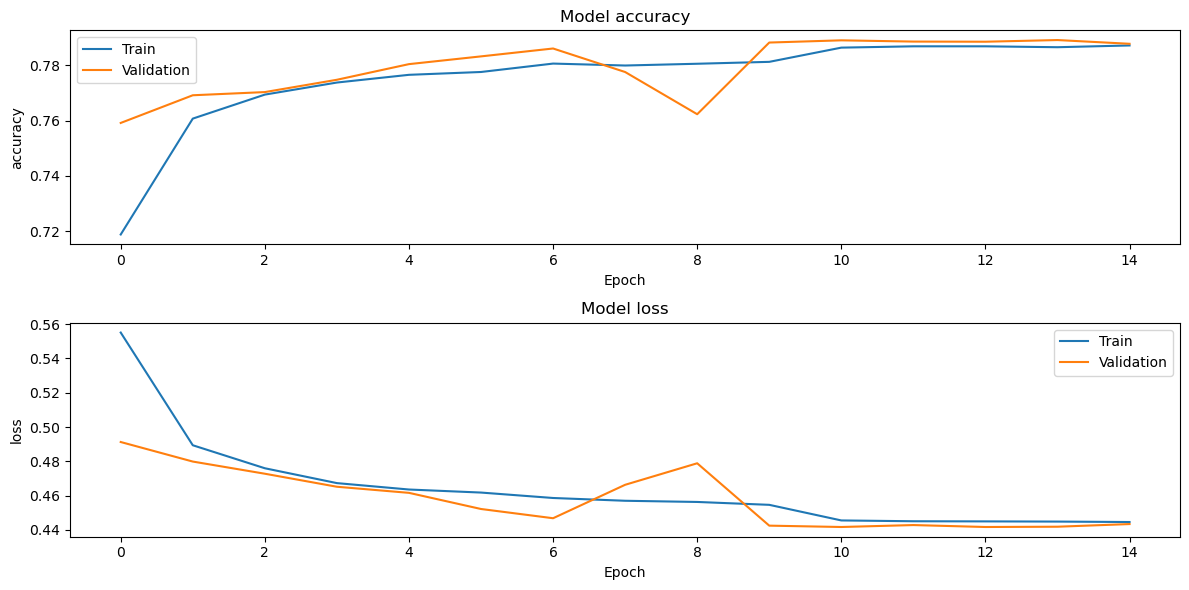

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric], label='Train')
    ax[i].plot(history.history[f'val_{metric}'], label='Validation')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend()

plt.tight_layout()
plt.show()